In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.5.0


## Notes


Priority:

- Use full dataset
- CNN model (custom defined)
- Trim off outliers (price more than a particular threshold)
- Scale down target column or scale down loss (custom loss)
- Hybrid model - Definitely do this
- Check out data generator parameters

Others:

- Learning rate
- Change activation function to maybe linear?
- Optimizers
- Unfreezing some of the lower layers
- More epochs - upto 50?
- Fewer units in dense layer
- Higher batch size (8,16)

In [3]:
# Load the training and validation dataset and labels

train_label_df = pd.read_excel("dataset_splits/cleaned_train_data.xlsx")
test_label_df = pd.read_excel("dataset_splits/cleaned_test_data.xlsx")

In [4]:
train_label_df.columns[:30]

Index(['pictureid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'roomcnt', 'yearbuilt', 'numberofstories', 'taxvaluedollarcnt',
       'assessmentyear', 'propertycountylandusecode_1',
       'propertycountylandusecode_34', 'propertycountylandusecode_38',
       'propertycountylandusecode_96', 'propertycountylandusecode_122',
       'propertycountylandusecode_135', 'propertylandusetypeid_246',
       'propertylandusetypeid_247', 'propertylandusetypeid_248',
       'propertylandusetypeid_261', 'propertylandusetypeid_266',
       'regionidcity_5465.0', 'regionidcity_6285.0', 'regionidcity_8384.0'],
      dtype='object')

In [5]:
train_label_df.head()

,pictureid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,...,censustractandblock_60590200000000,censustractandblock_60590300000000,censustractandblock_60590400000000,censustractandblock_60590500000000,censustractandblock_60590600000000,censustractandblock_60590700000000,censustractandblock_60590800000000,censustractandblock_60590900000000,censustractandblock_60591000000000,censustractandblock_60591100000000
0,0,5.5,5,5.5,5042,5,4,988,33509223,-117672518,...,0,0,1,0,0,0,0,0,0,0
1,1,1.5,3,1.5,1695,1,1,360,33820017,-117971956,...,0,0,0,0,0,0,0,1,0,0
2,2,2.0,4,2.0,1460,2,2,456,33677514,-117954806,...,0,0,0,0,0,0,0,0,1,0
3,3,1.0,2,1.0,1296,1,1,288,33744721,-117863804,...,0,0,0,0,0,0,1,0,0,0
4,4,2.0,3,2.0,1397,2,1,360,33756060,-117875860,...,0,0,0,0,0,0,1,0,0,0


In [6]:
train_label_df["target_scaled_down"] = train_label_df["taxvaluedollarcnt"]/1e5
test_label_df["target_scaled_down"] = test_label_df["taxvaluedollarcnt"]/1e5

In [7]:
train_label_df["target_scaled_down"].max()

216.44655

In [8]:
# Pick threshold to cut off outliers

threshold_value_saved = np.percentile(np.array(train_label_df["target_scaled_down"]), 99)
print(threshold_value_saved)

26.647402400000004


In [9]:
# 10,000,000

In [10]:
# Removing outliers
train_label_df = train_label_df.loc[train_label_df["target_scaled_down"] < threshold_value_saved]
test_label_df = test_label_df.loc[test_label_df["target_scaled_down"] < threshold_value_saved]

In [11]:
print(f"Train df: {len(train_label_df)}, test df: {len(test_label_df)}")

Train df: 14849, test df: 4955


In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    #horizontal_flip = None, 
    #fill_mode = "nearest", 
    #zoom_range = 2, 
    #width_shift_range = None, 
    #height_shift_range = None,
    #rotation_range=None
) 

In [13]:
train_label_df["picturepath"] = train_label_df["pictureid"].astype(str).apply(lambda x: f"pic_{x}.png")

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_label_df, 
    directory = "dataset_splits/all_data_pics/train_data_pics/", 
    x_col = "picturepath", 
    y_col="target_scaled_down", 
    class_mode = "raw", 
    target_size= (400, 400), 
    batch_size = 4
)

Found 14849 validated image filenames.


In [15]:
valid_datagen = ImageDataGenerator(
    rescale = 1./255, 
    #horizontal_flip = None, 
    #fill_mode = "nearest", 
    #zoom_range = 2, 
    #width_shift_range = None, 
    #height_shift_range = None,
    #rotation_range=None
) 

In [16]:
test_label_df["picturepath"] = test_label_df["pictureid"].astype(str).apply(lambda x: f"pic_{x}.png")

In [17]:
validation_generator = valid_datagen.flow_from_dataframe(
    dataframe = test_label_df, 
    directory = "dataset_splits/all_data_pics/test_data_pics/", 
    x_col = "picturepath", 
    y_col="target_scaled_down", 
    class_mode = "raw", 
    target_size= (400, 400), 
    batch_size = 4
)

Found 4955 validated image filenames.


In [18]:
import tensorflow as tf

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential

In [24]:
# Set up a CNN
model = Sequential([
    # Convolution (x64) with 3 bytes color, input shape of 400x400 with 3 bytes color
    Conv2D(64,(3,3), activation="relu", input_shape=(400,400, 3)),
    MaxPooling2D(2,2),
    # The second convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    # Dropout to avoid overfitting
    Dropout(0.5),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    # Last layer is a linear layer predicting a single continuous number (the price)
    Dense(1, activation='linear')
])

# Compile model
# Loss is "mse" for continiuous output

model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

In [21]:
# # To load previous checkpoint

# checkpoint_path = "CNN_checkpoints/v1.0.0/checkpoint.hdf5"

# # Load model from checkpoint
# try: 
#     print('** trying to load latest checkpoint')
#     model.load_weights( checkpoint_path )
#     print('** loaded latest checkpoint')
# except OSError:
#     print('** loading model from scratch')

In [25]:
checkpoint_dir = "CNN_checkpoints/v2.0.0"

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [26]:
# Train
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=15,
    steps_per_epoch=250,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint( 
            filepath = f'{checkpoint_dir}/checkpoint.hdf5',
            save_weights_only = True, 
            verbose = 1, 
            save_freq = 3000, # Save every 2000 batches/steps
        ),
        #tf.keras.callbacks.EarlyStopping( monitor='loss', patience=3 ),
    ],
    verbose=1
)

Epoch 1/15
250/250 [==============================] - 38s 149ms/step - loss: 15.2335 - mse: 15.2335 - mae: 2.7205 - val_loss: 14.2733 - val_mse: 14.2733 - val_mae: 2.6270
Epoch 2/15
250/250 [==============================] - 37s 148ms/step - loss: 15.9520 - mse: 15.9520 - mae: 2.7879 - val_loss: 14.1922 - val_mse: 14.1922 - val_mae: 2.5936
Epoch 3/15
250/250 [==============================] - 37s 147ms/step - loss: 16.0502 - mse: 16.0502 - mae: 2.7734 - val_loss: 14.0755 - val_mse: 14.0755 - val_mae: 2.5658
Epoch 4/15
250/250 [==============================] - 37s 148ms/step - loss: 15.0397 - mse: 15.0397 - mae: 2.7454 - val_loss: 15.6611 - val_mse: 15.6611 - val_mae: 2.5486
Epoch 5/15
250/250 [==============================] - 37s 148ms/step - loss: 13.7551 - mse: 13.7551 - mae: 2.5888 - val_loss: 14.4550 - val_mse: 14.4550 - val_mae: 2.8291
Epoch 6/15
250/250 [==============================] - 37s 149ms/step - loss: 14.9530 - mse: 14.9530 - mae: 2.7916 - val_loss: 14.7313 - val_mse: 

In [27]:
history_df = pd.DataFrame(history.history) 

In [28]:
# Plot utility
def plot_graphs(history_object_df, string):
  plt.plot(history_object_df[string])

  if "val_loss" in history_object_df.columns:
    plt.plot(history_object_df['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

  else:
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

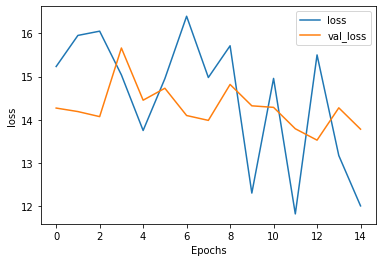

In [29]:
# # adam 50 epochs, 4 batch size
plot_graphs(history_df, "loss")

In [30]:
# # Hybrid model

# # Image Layers
# # Convolution 1
# conv1 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", input_shape=(150,150, 3))(image_data)
# pool1 = tf.keras.layers.MaxPooling2D(2,2)(conv1)

# # Convolution 2
# conv2 = tf.keras.layers.Conv2D(64,(3,3), activation="relu", input_shape=(150,150, 3))(pool1)
# pool2 = tf.keras.layers.MaxPooling2D(2,2)(conv2)

# # Convolution 3
# conv3 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(pool2)
# pool3 = tf.keras.layers.MaxPooling2D(2,2)(conv3)

# # Convolution 3
# conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(pool3)
# pool4 = tf.keras.layers.MaxPooling2D(2,2)(conv4)

# # Flatten the results to feed into a DNN
# image_layer = tf.keras.layers.Flatten()(pool4)

# # Dropout to avoid overfitting
# if training:
#     image_layer = tf.keras.layers.Dropout(0.5)(image_layer)


# # Add numerical data
# hybrid = tf.concat([image_layer, num_data], axis=-1)
# # Normalize
# hybrid = tf.keras.layers.LayerNormalization(epsilon=1e-6)(hybrid)


# # Final linear regression layer
# # 512 neuron hidden layer
# output = tf.keras.layers.Dense(512, activation='relu')

# model = tf.keras.Model(inputs=[image_data, num_data], outputs=[output])

